# Importações

In [3]:
import pandas as pd
import numpy as np

from joblib import load

from lime.lime_tabular import LimeTabularExplainer

In [4]:
model = load('models/rf_best_model.joblib')

train_df = pd.read_csv('data/train_data.csv')
test_df = pd.read_csv('data/test_data.csv')

target = 'Kingdom_group_encoded'
labels = ['Animalia', 'Bacteria', 'Plantae', 'Virus']

X_train = train_df.drop(target, axis=1)
y_train = train_df[target]

X_test = test_df.drop(target, axis=1)
y_test = test_df[target]

# Local Surrogate Model - LIME

A explicabilidade local com LIME busca entender por que um modelo complexo (por exemplo, uma Random Forest) tomou uma decisão específica para uma amostra individual. O LIME constrói automaticamente um modelo substituto simples (por padrão, um modelo linear) ao redor da amostra, usando amostras perturbadas e um kernel de proximidade, e apresenta as contribuições locais das features que mais influenciaram a predição.

Passo a passo conceitual
1. Escolher a amostra x0 que se deseja explicar (exemplo: uma linha de X_test).
2. Gerar variações de x0, o LIME cria automaticamente amostras parecidas perturbando suas features.
3. Obter as previsões do modelo complexo (predict_proba) para essas amostras perturbadas
4. Aplicar pesos de proximidade, dando mais importância às amostras mais parecidas com x0.
5. Treinar um modelo simples local (geralmente linear) com essas amostras ponderadas.
6. Interpretar a explicação local: as features com pesos positivos aumentam a probabilidade da classe prevista; as com pesos negativos a reduzem.

### Resultados:

O modelo classificou essa amostra como pertencente ao grupo Animalia com probabilidade de 1.00, indicando alta confiança na decisão. A explicação local mostra que essa escolha foi influenciada principalmente pela baixa frequência dos códons GAU e AGG e pela alta frequência dos códons CUA e UGA, padrões de organismos animais. Outros códons, como UGU, GCG, UUC e CCC, também contribuíram, mas com menor peso. Em resumo, o modelo reconheceu um perfil de uso de códons característico de Animalia, distinguindo-o claramente de Bacteria, Plantae e Virus.

In [57]:
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=list(X_train.columns) if hasattr(X_train, "columns") else None,
    class_names=labels,
    mode='classification',
    discretize_continuous=True,   
    random_state=42
)

i = 5  # índice da amostra
exp = explainer.explain_instance(
    data_row=X_test.iloc[i] if hasattr(X_test, "iloc") else X_test[i],
    predict_fn=model.predict_proba,
    num_features=10,     
    num_samples=5000    
)


c:\Users\italo\Documents\Faculdade\7_Periodo\taic\model_interpretability_project\.venv\lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\italo\Documents\Faculdade\7_Periodo\taic\model_interpretability_project\.venv\lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\italo\Documents\Faculdade\7_Periodo\taic\model_interpretability_project\.venv\lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__ge

In [58]:
local_list = exp.as_list(label=exp.available_labels()[0] if hasattr(exp, "available_labels") else None)

In [59]:
exp.show_in_notebook(show_table=True)

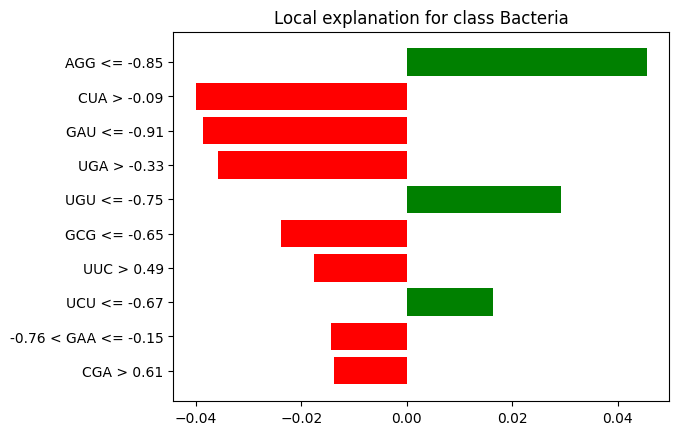

In [60]:
fig = exp.as_pyplot_figure()
fig.set_facecolor('white')

# SHAP

### Resultados:

Para compreender como o modelo processa instâncias individuais, aplicamos o método SHAP (SHapley Additive exPlanations) em dois cenários distintos: uma predição correta com alta confiança e uma classificação de fronteira com baixa certeza

-  Ao analisarmos uma instância classificada corretamente como Virus (Probabilidade final: 81.4%), o gráfico Waterfall confirma as regras globais observadas anteriormente nos PDPs:
    - Confirmação por Negação: O modelo utilizou o baixo valor do códon CUU (típico de Plantas) como uma forte evidência positiva (+0.03) para a classe Virus. O modelo raciocina que a ausência de características de plantas reforça a probabilidade de ser um vírus.
    - Decisão Distribuída: A maior contribuição para a nota final (+0.42) veio do somatório de "55 other features". Isso demonstra a robustez do Random Forest: a decisão não se baseia em um único biomarcador ("bala de prata"), mas na agregação de dezenas de pequenos sinais genéticos correlacionados.


- Em contrapartida, a análise de uma instância classificada como Virus com baixa confiança (33.8%, pouco acima do acaso) revela como surgem os erros ou dúvidas do modelo:
    - Conflito de Evidências: As features principais emitiram sinais contraditórios. A instância apresentava CUU alto e ACA baixo — uma assinatura clássica de Plantae segundo nossa análise global. O SHAP capturou isso corretamente através das barras azuis (negativas), que tentaram reduzir a probabilidade de Virus.
    - O "Desempate" Marginal: Apesar dos fortes sinais negativos das features principais, o modelo optou pela classe Virus devido ao acúmulo de contribuições positivas de features secundárias (como UGU e UGC).
    
Conclusão Local: O SHAP evidencia que o modelo é altamente confiável quando as features principais (CUU, ACA, CUG) estão alinhadas. No entanto, em organismos "atípicos" onde esses marcadores principais se contradizem, o modelo torna-se instável, decidindo a classificação pelo acúmulo marginal de variáveis de menor importância.

In [5]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(model)

X_test_sample = X_test.sample(100, random_state=42)
y_test_sample = y_test.loc[X_test_sample.index]

shap_values = explainer(X_test_sample)

# IMPORTANTE: Como é multiclasse, o shap_values terá dimensões (amostras, features, classes)
print(f"Dimensões do SHAP: {shap_values.shape}")

Dimensões do SHAP: (100, 64, 4)


In [6]:
# Fazer predições na amostra para comparar
preds = model.predict(X_test_sample)

# Encontrar índices
indices_corretos = np.where(preds == y_test_sample)[0]
indices_erros = np.where(preds != y_test_sample)[0]

print(f"Exemplos de acertos (índices): {indices_corretos[:5]}")
print(f"Exemplos de erros (índices): {indices_erros[:5]}")

# Vamos pegar um exemplo de cada.
idx_acerto = indices_corretos[0] if len(indices_corretos) > 0 else 0
idx_erro = indices_erros[0] if len(indices_erros) > 0 else indices_corretos[1]

Exemplos de acertos (índices): [0 1 2 3 4]
Exemplos de erros (índices): [10 12 14 88]


/Users/jvlm/repositories/model_interpretability_project/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [7]:
def plot_shap_waterfall(shap_obj, index, class_idx, class_names, data_sample):
    """
    Plota o waterfall plot para uma instância específica e uma classe específica.
    """
    # Recupera o nome da classe alvo
    class_name = class_names[class_idx]
    
    # Prepara o objeto SHAP fatiando para a amostra (index) e a classe (class_idx)
    # shap_obj[amostra, :, classe]
    shap_explanation = shap_obj[index, :, class_idx]
    
    # Configura o gráfico
    plt.figure()
    shap.plots.waterfall(shap_explanation, show=False, max_display=10)
    plt.title(f"Explicação Local SHAP - Instância {index}\nPor que classificado como '{class_name}'?", fontsize=14)
    plt.show()

--- ANÁLISE DO ACERTO (Instância 0) ---
Real: Virus | Predito: Virus


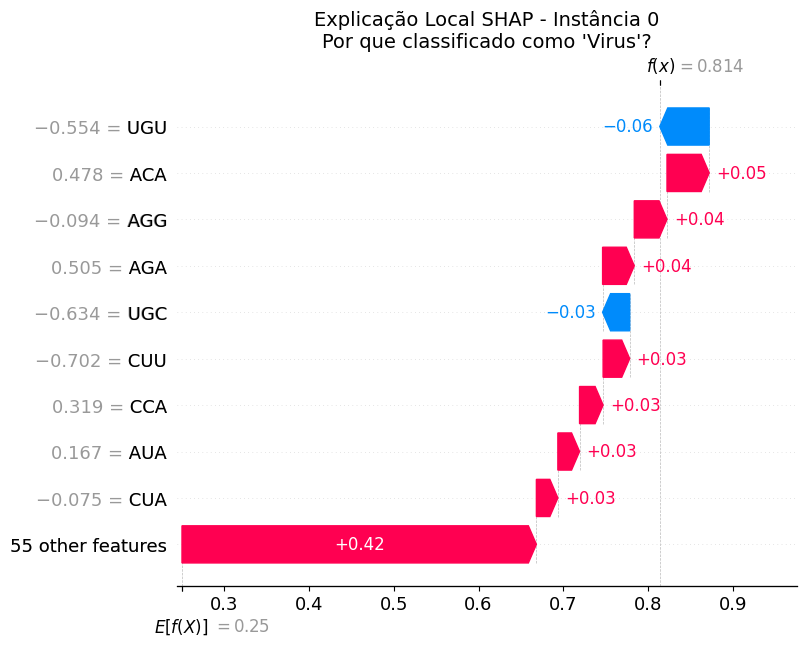

In [8]:
# 1. Analisando o caso de ACERTO
classe_predita_acerto = int(preds[idx_acerto]) 
true_label_acerto = labels[int(y_test_sample.iloc[idx_acerto])]

print(f"--- ANÁLISE DO ACERTO (Instância {idx_acerto}) ---")
print(f"Real: {true_label_acerto} | Predito: {labels[classe_predita_acerto]}")

# Gerar o gráfico explicando por que o modelo escolheu essa classe
plot_shap_waterfall(shap_values, idx_acerto, classe_predita_acerto, labels, X_test_sample)


--- ANÁLISE DO ERRO/OUTRO (Instância 10) ---
Real: Bacteria | Predito: Virus


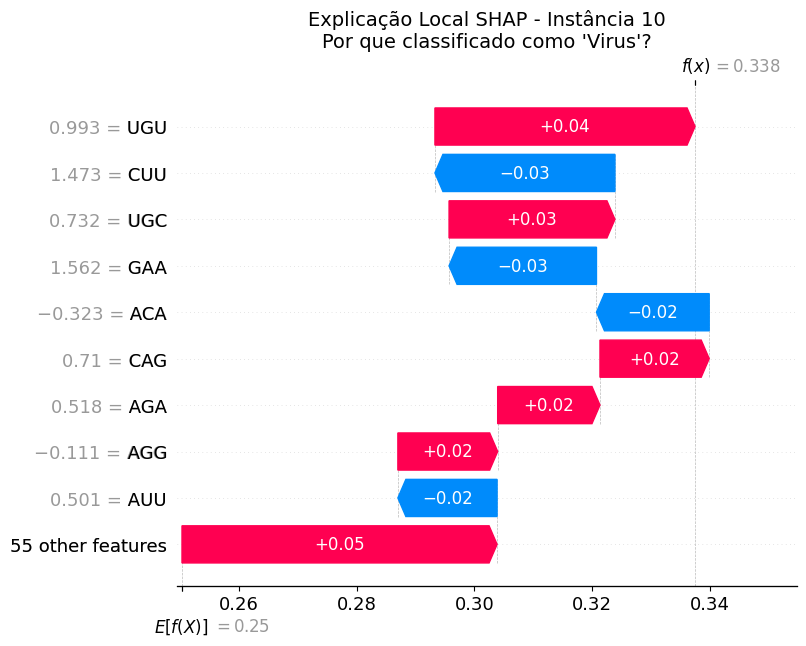

In [9]:
# 2. Analisando o caso de ERRO (ou outro acerto se não houver erros)
classe_predita_erro = int(preds[idx_erro])
true_label_erro = labels[int(y_test_sample.iloc[idx_erro])]

print(f"\n--- ANÁLISE DO ERRO/OUTRO (Instância {idx_erro}) ---")
print(f"Real: {true_label_erro} | Predito: {labels[classe_predita_erro]}")

# Aqui é interessante ver: Por que ele escolheu a classe ERRADA?
plot_shap_waterfall(shap_values, idx_erro, classe_predita_erro, labels, X_test_sample)